In [1]:

import sys
sys.path.append("..")
from BacktestApp import BacktestApp
from utils import vwap, is_within_specific_minutes_of_close
from PositionManagerPlus import PositionManager

import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from numba import njit

@njit
def search_backward(prices, start, end, target):
    """
    在 prices 数组中，从索引 start 到 end（包含两端），
    从后往前搜索第一个等于 target 的值，并返回该索引。
    如果未找到，则返回 -1。
    """
    for idx in range(end, start - 1, -1):
        if prices[idx] == target:
            return idx
    return -1

@njit
def zigzag_numba(prices, pct, window):
    """
    使用 numba 实现基于百分比阈值和窗口周期的波段分段识别，
    在检测到反转时调用 search_backward，在指定区域从后往前寻找目标价格的索引，
    并更新 pivot_index。
    
    参数:
      prices: 收盘价数组
      pct: 反转百分比阈值（例如 0.02 表示 2%）
      window: 构成趋势的最小周期（K线数量）
    
    返回:
      group_ids: 每根K线所属的组编号（及时更新）
      pivot_flags: 每根K线是否为初步拐点标识
    """
    n = len(prices)
    group_ids = np.zeros(n, dtype=np.int64)
    pivot_flags = np.zeros(n, dtype=np.bool_)
    
    pivot_index = 0           # 当前拐点索引
    pivot_flags[0] = True     # 首个点作为拐点
    direction = 0             # 0: 尚未确定，1: 上升趋势，-1: 下跌趋势
    group_id = 0              # 初始组号
    group_ids[0] = group_id
    last_confirmed_idx = 0    # 上一次确认拐点的索引

    for i in range(1, n):
        change = (prices[i] - prices[pivot_index]) / prices[pivot_index]
        if direction == 0:
            # 尚未确定趋势，等待价格变化达到阈值
            if change >= pct:
                direction = 1
                pivot_index = i
                pivot_flags[i] = True
                # 更新从上一次确认点到当前的 group_id
                for j in range(last_confirmed_idx + 1, i + 1):
                    group_ids[j] = group_id
                last_confirmed_idx = i
            elif change <= -pct:
                direction = -1
                pivot_index = i
                pivot_flags[i] = True
                for j in range(last_confirmed_idx + 1, i + 1):
                    group_ids[j] = group_id
                last_confirmed_idx = i
        else:
            if direction == 1:
                # 上升趋势中：若出现更高的价格则更新 pivot_index
                if prices[i] > prices[pivot_index]:
                    pivot_index = i
                    pivot_flags[i] = True
                # 检查是否出现足够幅度的反转（回调）
                if (prices[pivot_index] - prices[i]) / prices[pivot_index] >= pct and (i - last_confirmed_idx) >= window:
                    # 调用 search_backward，在 last_confirmed_idx+1 到 i 范围内，从后往前寻找与当前 pivot 相同的价格，
                    # 如果找到，则将 pivot_index 更新为这个索引（确保选取最近确认的拐点）。
                    new_pivot = search_backward(prices, last_confirmed_idx + 1, i, prices[pivot_index])
                    if new_pivot != -1:
                        pivot_index = new_pivot
                    # 更新组：将上一次确认点到当前的 group_id 赋值
                    for j in range(last_confirmed_idx + 1, i + 1):
                        group_ids[j] = group_id
                    last_confirmed_idx = pivot_index
                    direction = -1  # 反转为下跌趋势
                    pivot_flags[i] = True
                    group_id += 1
            elif direction == -1:
                # 下跌趋势中：若出现更低的价格则更新 pivot_index
                if prices[i] < prices[pivot_index]:
                    pivot_index = i
                    pivot_flags[i] = True
                # 检查是否出现足够幅度的反转（反弹）
                if (prices[i] - prices[pivot_index]) / prices[pivot_index] >= pct and (i - last_confirmed_idx) >= window:
                    new_pivot = search_backward(prices, last_confirmed_idx + 1, i, prices[pivot_index])
                    if new_pivot != -1:
                        pivot_index = new_pivot
                    for j in range(last_confirmed_idx + 1, i + 1):
                        group_ids[j] = group_id
                    last_confirmed_idx = pivot_index
                    direction = 1  # 反转为上升趋势
                    pivot_flags[i] = True
                    group_id += 1
        group_ids[i] = group_id  # 确保每个点都有赋值
    return group_ids, pivot_flags

def identify_trend_groups_vectorized(df, amp_pct, window):
    """
    对 df 进行波段分组识别，amp_pct 为百分比阈值（例如 0.02 表示 2%），window 为最小周期。
    返回的 df 中增加：
      - group_id: 分组编号
      - pivot: 初步识别的局部拐点（True/False）
    这里采用 numba 加速的 zigzag 算法。
    """
    prices = df['close'].values.astype(np.float64)
    group_ids, pivot_flags = zigzag_numba(prices, amp_pct, window)
    df = df.copy()
    df['group_id'] = group_ids
    df['pivot'] = pivot_flags
    return df

def identify_pivots_by_group_vectorized(df):
    """
    对每个 group_id 内，依据整体趋势确定关键 pivot 点，并在新列 pivot_group 中标记 True。
    思路：
      - 若组内最后价格高于首个价格，则为上升趋势，选组内最低 low 作为转折 pivot（通常为整理后的低点）。
      - 否则为下跌趋势，选组内最高 high 作为 pivot。
    """
    df = df.copy()
    df['pivot_group'] = False
    for group, sub in df.groupby('group_id'):
        if sub.empty:
            continue
        # 判断组内整体趋势
        if sub['close'].iloc[-1] >= sub['close'].iloc[0]:
            # 下跌趋势：选择最高 high 作为 pivot
            idx = sub['high'].idxmax()
        else:
            # 上升趋势：选择最低 low 作为 pivot
            idx = sub['low'].idxmin()

        df.loc[idx, 'pivot_group'] = True
    return df

def fit_piecewise_segments(df, x_col, y_col, count, plot=False, highlight=None):
    """
    使用分段拟合对数据进行 Piecewise Regression (支持时间作为 X 轴)

    参数:
    - df: pd.DataFrame, 需要包含 x_col 和 y_col 两列
    - x_col: str, 作为 X 轴的列名 (如果是时间列，会自动转换为数值)
    - y_col: str, 作为 Y 轴的列名
    - count: int, 需要分的段数

    返回:
    - px: np.ndarray, 分段的 x 轴坐标（原始时间格式）
    - py: np.ndarray, 分段的 y 轴坐标
    """
    # 转换时间列为数值（时间戳 -> 秒级浮点数）
    X = pd.to_datetime(df[x_col]).astype(np.int64) / 1e9  # 转换为秒
    Y = df[y_col].values

    xmin = X.min()
    xmax = X.max()

    # 计算初始分段点
    seg = np.full(count - 1, (xmax - xmin) / count)
    px_init = np.r_[np.r_[xmin, seg].cumsum(), xmax]
    py_init = np.array([Y[np.abs(X - x) < (xmax - xmin) * 0.01].mean() for x in px_init])

    def func(p):
        seg = p[:count - 1]
        py = p[count - 1:]
        px = np.r_[np.r_[xmin, seg].cumsum(), xmax]
        return px, py

    def err(p):
        px, py = func(p)
        Y2 = np.interp(X, px, py)
        return np.mean((Y - Y2) ** 2)

    r = optimize.minimize(err, x0=np.r_[seg, py_init], method='Nelder-Mead')

    # 将 px 转回时间格式
    px, py = func(r.x)
    px = pd.to_datetime(px * 1e9)  # 秒 -> 纳秒时间戳
    slope = (py[1] - py[0]) / py[0] * 1000
    if plot:
        plt.plot(df[x_col], df[y_col], ".")
        plt.plot(px, py, "-or")
        if highlight:
            # 找到对应的 y 值
            highlight_y = df.loc[df[x_col] == highlight, y_col].values[0]  # 获取对应的 y 值
            # 标红该点
            plt.scatter(highlight, highlight_y, color='red', s=80, zorder=3)
    return slope

class Trend:
    def __init__(self, contract, pm:PositionManager):
        self.contract = contract
        self.pm = pm
        
        self.vwap_slope_threhold = 0.07
        self.close_pct_change_threhold = 0.07
        self.ampitude_range = []
        self.debug_slice = []
        self.post_buy_pattern = None
        self.open_position_df = None
        
    def calculate_open_amount(self, bars):
        if self.pm.net_liquidation is None or self.pm.available_funds is None:
            print("PositionManager.calculate_open_amount net_liquidation or available_funds is None")
            return 0
        
        target_market_value = self.pm.net_liquidation * 0.5
        if target_market_value > self.pm.available_funds: return 0
        
        open_amount = target_market_value / bars.iloc[-1]['close']
        open_amount = round(open_amount / 10) * 10  # 调整为 10 的倍数
        return int(open_amount)

    def find_position(self):
        is_match = lambda item: (
            item["contract"] == self.contract and
            item["strategy"] == "Trend"
        )
        return self.pm.find_position(is_match)
    
    def setParams(self, bars, window=8, amp_pct=0.005):
        # if len(bars) < window: return
        bars['ema_10'] = bars['close'].ewm(span=10, adjust=False).mean()        
        
        df_trend = identify_trend_groups_vectorized(bars, amp_pct, window)
        bars = identify_pivots_by_group_vectorized(df_trend)
        return bars
    
    def get_open_signal(self, bars):
        if len(self.ampitude_range) == 0: return None
        signal = None
        compare_ampitude_range = None
        # 当前bars最新一根行情是震荡，且前一根也是震荡的情况
        # 其实当前区域突破了前一个震荡区间，增加判定以使用前一个震荡区间的值
        if self.ampitude_range[-1].iloc[-1]["date"] == bars.iloc[-1]["date"]:
            if len(self.ampitude_range) > 1:
                compare_ampitude_range = self.ampitude_range[-2]
        else:
            compare_ampitude_range = self.ampitude_range[-1]
            
        if compare_ampitude_range is not None:
            if bars.iloc[-1]["date"] - compare_ampitude_range.iloc[-1]["date"] > pd.Timedelta(minutes=20):
                return None
            if bars.iloc[-1]["close"] > compare_ampitude_range["close"].max():
                return "做多"
            if bars.iloc[-1]["close"] < compare_ampitude_range["close"].min():
                return "做空"
        return signal
    
    def get_close_signal(self, position, bars):
        """
        返回格式 减仓比例, 减仓原因
        减仓条件：
        1. 开仓后价格直接回到成交时的区间中轨，平仓（强制）
        2. 从最高点回落一半,平半仓（假突破）,回落到开仓价位以下时，再平半仓
        3. 如果走出单边走势,破ema10, 区间长度需要超过10分钟(止盈)
        """
        amount = position["amount"]
        
        ## 条件一
        middle_price = (self.open_position_df["close"].max() + self.open_position_df["close"].min()) / 2
        if (bars.iloc[-1]["close"] < middle_price and amount > 0) or \
            (bars.iloc[-1]["close"] > middle_price and amount < 0):
                print(f'开仓时的时间点{self.open_position_df.iloc[0]["date"]}-{self.open_position_df.iloc[-1]["date"]} 中枢价格{middle_price} 当前价格{bars.iloc[-1]["close"]}')
                return 1, f"价格回落开仓区间中枢"
        
        ## 条件二
        df = bars[bars["date"] >= position["date"]]
        
        drawdown_ratio = 0.5
        max_profit_price = df["close"].min() if amount < 0 else df["close"].max()
        init_price = df.iloc[0]["close"]
        current_price = df.iloc[-1]["close"]
        # 区域限定的mask
        mask = (max_profit_price > current_price > init_price and amount > 0) or \
                (max_profit_price < current_price < init_price and amount < 0)
        # 回落比例 = (max_profit_price - current_price) / (max_profit_price - current_price)
        if len(df) > 3 \
            and (max_profit_price - init_price) != 0 \
            and (max_profit_price - current_price) / (max_profit_price - init_price) >= drawdown_ratio \
            and mask \
            and abs((current_price - init_price) / init_price) >= 0.002 \
            and position["amount"] == position["init_amount"]:
                self.post_buy_pattern = "回落走势"
                return 0.5, f"从最高点回落超过{drawdown_ratio}"
            
        if self.post_buy_pattern == "回落走势" \
            and ((current_price < init_price and amount > 0) or (current_price > init_price and amount < 0)):
            return 0.5, f"从最高点回落超过{drawdown_ratio}"
    
    def update(self, bars):
        if len(bars) < 60: return
        # bars = self.setParams(bars, debug=False)
        df_slice = bars.iloc[-60:]
        if bars.iloc[-1]["range_pct"] < 0.005 and \
            abs(bars.iloc[-1]["slope"]) <= 1 and \
            abs(bars.iloc[-1]["ema_10_diff_window_begin"]) < 0.001:
            self.ampitude_range.append(df_slice)
        
        # 反手信号（平仓部分）
        position = self.find_position()
        open_single = self.get_open_signal(bars)
        if open_single:
            direction = 1 if open_single == "做多" else -1
            if position and direction * position["amount"] < 0:
                self.pm.close_position(position, bars)
                self.open_position_df = None
        
        # 开仓信号
        position = self.find_position()
        if open_single and not position and not is_within_specific_minutes_of_close(bars, 60):
            direction = 1 if open_single == "做多" else -1
            amount = direction * self.calculate_open_amount(bars)
            self.pm.open_position(self.contract, "Trend", amount, bars)
            self.open_position_df = df_slice
            self.debug_slice.append({
                "df": self.ampitude_range[-1],
                "date": bars.iloc[-1]["date"],
                "index": bars.iloc[-1].name
            })
        
        # 收盘前平仓
        position = self.find_position()
        if position and is_within_specific_minutes_of_close(bars, 5):
            self.pm.close_position(position, bars)
        
        # 常规止盈止损
        position = self.find_position()
        if position:
            close_signal = self.get_close_signal(position, bars)
            if close_signal:
                close_pct, reason = close_signal
                substract_amount = position["init_amount"] * close_pct
                if (substract_amount < position["amount"] and substract_amount > 0) or \
                    (substract_amount > position["amount"] and substract_amount < 0):
                    self.pm.substract_position(position, close_pct, bars, reason=reason)
                else:
                    self.pm.close_position(position, bars, reason=reason)
                    self.open_position_df = None
                    
class TrendBacktestApp(BacktestApp):
    def __init__(self, config_file="config.yml", **kwargs):
        super().__init__(config_file, **kwargs)
        self.trend = { contract.symbol: Trend(contract, self.pm) for contract in self.contracts }
        
    def on_bar_update(self, contract, bars, has_new_bar):
        bars = bars.copy()
        self.trend[contract.symbol].update(bars)

try:
    ba = TrendBacktestApp(config_file="../config_backtest.yml", clientId=20, debug=True, autoConnect=False)
    end_date = "2025-02-24"
    duration_str = "200 D"
    # ba.minutes_backtest(end_date, duration_str, pre_process_bar_callback=ba.trend[ba.contracts[0].symbol].setParams)
finally:
    if ba.ib: pass
        # ba.ib.disconnect()

37 2024-07-01


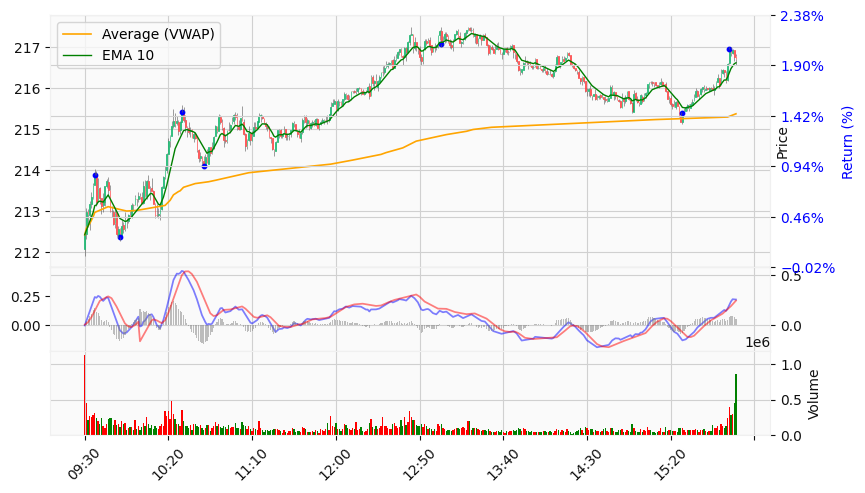

In [2]:
from PlotPlus import PlotPlus
idx = 37
daily = ba.get_historical_data(ba.contracts[0], end_date, duration_str, '1 day')

while True:
    date = daily.iloc[idx]['date']
    print(idx, date)
    idx += 1
    df = ba.get_historical_data(ba.contracts[0], date)
    st = Trend(ba.contracts[0], ba.pm)
    df = st.setParams(df, window=8)
    
    pp = PlotPlus(df)
    pp.plot_basic(style_type="candle")
    # pp.mark_segment("slope_segment")
    pivot_point = df[df["pivot_group"]]
    pp.mark_point(pivot_point, "close")
    pp.mark_bs_point(ba.pm.trade_log)
    pp.show()
    
    break

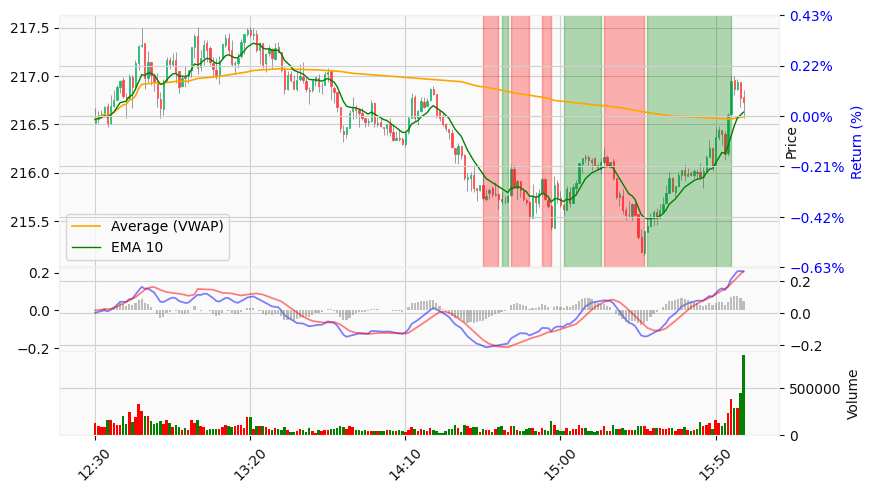

In [32]:
from Region import find_pulse_regions
def mark_region(df):
    df = df.copy()
    df['region'] = 'sideway'

    df_trim, up_candidates, use_noise = find_pulse_regions(df, direction=1, window=90, min_window=3)
    df_trim, down_candidates, use_noise = find_pulse_regions(df, direction=-1, window=90, min_window=3)

    for item in up_candidates:
        df.loc[item["start"]:item["end"], 'region'] = 'up'

    for item in down_candidates:
        df.loc[item["start"]:item["end"], 'region'] = 'down'
        
    return df

df_trim = mark_region(df.iloc[180:390])
pp = PlotPlus(df_trim)
pp.plot_basic(style_type="candle")
pp.mark_segment("region", value="up", color="green")
pp.mark_segment("region", value="down", color="red")
# pivot_point = df[df["pivot_group"]]
# pp.mark_point(pivot_point, "close")
pp.mark_bs_point(ba.pm.trade_log)
pp.show()

In [599]:
pd.DataFrame(candidate_regions)

,start,end,slope,length,amplitude,time_distance,score
0,92,95,0.129333,4,0.28,83,-86.590667
1,96,114,0.038111,19,0.61,64,-82.351889
2,145,150,0.092914,6,0.31,28,-33.597086
3,170,177,0.097687,8,0.57,1,-8.332313


In [292]:
find_candidate_regions(df_trim, 1, 5, 3)

j is 1, prev_extreme is 216.47, current price is 216.38 noise_count is 1
j is 2, prev_extreme is 216.47, current price is 216.12 noise_count is 2
j is 3, prev_extreme is 216.47, current price is 216.3 noise_count is 3
j is 4, prev_extreme is 216.47, current price is 216.09 noise_count is 4
j is 5, prev_extreme is 216.47, current price is 215.94 noise_count is 5
j is 6, prev_extreme is 216.47, current price is 216.38 noise_count is 6
current 0 7
j is 6.0, prev_extreme is 216.38, current price is 216.38 noise_count is 0
j is 7.0, prev_extreme is 216.72, current price is 216.72 noise_count is 0
j is 8.0, prev_extreme is 217.14, current price is 217.14 noise_count is 0
j is 9.0, prev_extreme is 217.14, current price is 217.12 noise_count is 1
j is 10.0, prev_extreme is 217.14, current price is 217.01 noise_count is 2
j is 11.0, prev_extreme is 217.14, current price is 217.04 noise_count is 3
j is 12.0, prev_extreme is 217.27, current price is 217.27 noise_count is 0
j is 13.0, prev_extreme

[(5, 17), (23, 46), (43, 46), (54, 62), (68, 84)]

In [ ]:
ba.statistic()

In [ ]:
ba.plot_pnl()

In [ ]:
amp_pct = 0.004
window = 8

df_trend = identify_trend_groups_vectorized(df, amp_pct, window)
df_with_pivot = identify_pivots_by_group_vectorized(df_trend)

pd.set_option('display.max_rows', None)
# 查看部分结果
# print(df_with_pivot[['date', 'close', 'group_id', 'pivot', 'pivot_group']])

In [ ]:
pp = PlotPlus(df)
pp.plot_basic(style_type="candle")
pp.mark_segment("slope_segment")
pp.mark_point(df_with_pivot[df_with_pivot["pivot_group"]], "close")
pp.mark_bs_point(ba.pm.trade_log)
pp.show()